# Get preliminary packages 

In [18]:
import numpy as np
import xarray as xr
import xesmf
import glob
import pickle
from tqdm import tqdm

# Specify some constants

In [68]:
all_fcst_fields = {
    "Convective available potential energy":"cape",
    "Convective precipitation (water)":"acpcp",
    "Surface pressure":"sp",
    "Surface upward short-wave radiation flux":"suswrf",
    "Surface downward short-wave radiation flux":"sdswrf",
    "2 metre temperature":"t2m",
    "Cloud water":"cwat",
    "Precipitable water":"pwat",
    "Ice water mixing ratio":"icmr",
    "Cloud mixing ratio":"clwmr",
    "Rain mixing ratio":"rwmr",
    "Total Precipitation":"tp",
    "U component of wind":"u",
    "V component of wind":"v",
}

all_fcst_levels = {
    "Convective available potential energy": "surface",
    "Convective precipitation (water)": "surface",
    "Medium cloud cover": "middleCloudLayer",
    "Surface pressure": "surface",
    "Surface upward short-wave radiation flux": "surface",
    "Surface downward short-wave radiation flux": "surface",
    "2 metre temperature": "heightAboveGround",
    "Cloud water": "atmosphereSingleLayer",
   "Precipitable water": "atmosphereSingleLayer",
    "Ice water mixing ratio": "isobaricInhPa",
    "Cloud mixing ratio": "isobaricInhPa",
    "Rain mixing ratio": "isobaricInhPa",
    "Total Precipitation": "surface",
    "U component of wind": "isobaricInhPa",
    "V component of wind": "isobaricInhPa",
}

In [86]:
accumulated_fields = ["Convective precipitation (water)", "Total Precipitation"]
nonnegative_fields = [
    "Convective available potential energy",
    "Convective precipitation (water)",
    "Medium cloud cover",
    "Surface pressure",
    "Surface upward short-wave radiation flux",
    "Surface downward short-wave radiation flux",
    "2 metre temperature",
    "Cloud water",
    "Precipitable water",
    "Ice water mixing ratio",
    "Cloud mixing ratio",
    "Rain mixing ratio",
    "Total Precipitation",
]
lat_reg_b = np.arange(-14.0,25.25,0.25)[::-1] - 0.125
lon_reg_b = np.arange(19,55,0.25) - 0.125

#Load test IMERG data to get grid for regridding
data_path = glob.glob('IMERG_20221231_18.nc')

ds = xr.open_mfdataset(data_path[0])
lat_reg_IMERG = ds.latitude.values
lon_reg_IMERG = ds.longitude.values


# Load in and normalise files

In [54]:
def logprec(y):
    return np.log10(1.0 + y)

In [78]:
def regrid_and_normalise_data(field, date, time_idx,
                              all_fcst_fields=all_fcst_fields, 
                              all_fcst_levels=all_fcst_levels,
                             lon_reg_b=lon_reg_b,lat_reg_b=lat_reg_b,
                             lon_reg_IMERG=lon_reg_IMERG,
                             lat_reg_IMERG=lat_reg_IMERG):
    
    #Get grid-box centres
    lat_reg = 0.5 * (lat_reg_b[1:] + lat_reg_b[:-1])
    lon_reg = 0.5 * (lon_reg_b[1:] + lon_reg_b[:-1])

    # Get bounding box
    lat_reg_IMERG_b = np.append((lat_reg_IMERG - 0.05), lat_reg_IMERG[-1] + 0.05)
    lon_reg_IMERG_b = np.append((lon_reg_IMERG - 0.05), lon_reg_IMERG[-1] + 0.05)

    file = glob.glob("gfs"+str(date).replace('-','')+"*"+field.replace(' ','-')+"_"+all_fcst_levels[field]+".zarr")
    nc_file = xr.open_zarr(file[0])#.sel({'longitude':lon_reg_b,'latitude':lat_reg})
    nc_file = nc_file.sel({'longitude':lon_reg,'latitude':lat_reg})

    if all_fcst_levels[field] == "isobaricInhPa":
        nc_file = nc_file.sel({"isobaricInhPa": 200})

    short_name = all_fcst_fields[field]

    idx_x = nc_file[short_name].values.shape[1]
    idx_y = nc_file[short_name].values.shape[2]
    all_data = np.squeeze(nc_file[short_name].values)

    data1 = all_data[int((time_idx-30)/3)]
    data2 = all_data[int(1+((time_idx-30)/3))]
    data3 = all_data[int(2+((time_idx-30)/3))]
    data4 = np.nanmean(all_data[int((time_idx-30)/3):int(3+((time_idx-30)/3)),:,:], axis=0)
    data = np.stack([data1, data2, data3, data4], axis=-1)
    
    nc_file.close()

    grid_in = {"lon": lon_reg, "lat": lat_reg, "lon_b": lon_reg_b, "lat_b": lat_reg_b}

    # output grid has a larger coverage and finer resolution
    grid_out = {
        "lon": lon_reg_IMERG,
        "lat": lat_reg_IMERG,
        "lon_b": lon_reg_IMERG_b,
        "lat_b": lat_reg_IMERG_b,
    }

    regridder = xesmf.Regridder(grid_in, grid_out, "conservative")

    if field in nonnegative_fields:
        data = np.maximum(data, 0.0)  # eliminate any data weirdness/regridding issues

    if field in ["Convective precipitation (water)", "Total Precipitation"]:
        
        data = np.moveaxis(regridder(np.moveaxis(data, -1, 0)), 0, -1)

        return logprec(data)

    elif field in ["Surface pressure", "2 metre temperature"]:
        # these are bounded well away from zero, so subtract mean from ens mean (but NOT from ens sd!)
        data[:, :, :] -= fcst_norm[field]["mean"]
        data /= fcst_norm[field]["std"]
        data = np.moveaxis(regridder(np.moveaxis(data, -1, 0)), 0, -1)

        return data

    elif field in nonnegative_fields:

        try:
            data /= fcst_norm[field]["max"]
        except:
            ## Surface upward/downward short-wave radiation flux was previously simply called 
            ## Upward/Downward short-wave radiation flux 

            data /= fcst_norm[field.split("Surface ")[1].capitalize()]["max"]

        data = np.moveaxis(regridder(np.moveaxis(data, -1, 0)), 0, -1)

        return data

    elif field in ["U component of wind", "V component of wind"]:
        # winds
        data /= max(-fcst_norm[field]["min"], fcst_norm[field]["max"])

        data = np.moveaxis(regridder(np.moveaxis(data, -1, 0)), 0, -1)
        return data

    else:
        data = np.moveaxis(regridder(np.moveaxis(data, -1, 0)), 0, -1)

        return data
    

In [23]:
def load_hires_constants(batch_size=1):
    oro_path = "elev.nc"
    df = xr.load_dataset(oro_path)
    
    # Orography in m.  Divide by 10,000 to give O(1) normalisation
    z = df["elevation"].values
    z /= 10000.0
    df.close()

    lsm_path = "lsm.nc"
    df = xr.load_dataset(lsm_path)
    # LSM is already 0:1
    lsm = df["lsm"].values
    df.close()

    temp = np.stack([z, lsm], axis=-1)  # shape H x W x 2
    return temp[np.newaxis, ...] 

## First get normalisation constants

In [10]:
with open('FCSTNorm2021.pkl', "rb") as f:
        fcst_norm = pickle.load(f)

## Loop through all variables

In [79]:
import warnings

warnings.filterwarnings("ignore")

field_arrays = []
date = np.array(['2023-12-31'],dtype='datetime64[ns]')

time_idx = 30 #next day 6 a.m. is 30 hours ahead, can be modified to [36,42,48,54] i.e. to get
              #full 25-hr rainfall for next day from time of forecast issue using 6-hourly cGAN preds.

for field in tqdm(all_fcst_fields.keys()):

    field_arrays.append(regrid_and_normalise_data(field, date, time_idx))

field_arrays = np.concatenate(field_arrays,axis=-1) # lon x lat x 4*len(all_fcst_fields)
field_arrays = field_arrays[None,:,:,:] # 1 x lon x lat x 4*len(all_fcst_fields)
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:45<00:00,  3.28s/it]


In [80]:
field_arrays.shape

(1, 384, 352, 56)

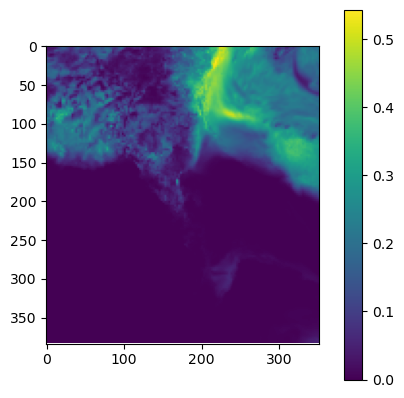

In [81]:
import matplotlib.pyplot as plt

im = plt.imshow(np.squeeze(field_arrays[:,:,:,3]))
plt.colorbar(im, fraction=0.4)

In [83]:
np.save("20231231_example.npy", field_arrays)